In [6]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout,Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM


In [7]:
movie_reviews = pd.read_csv("IMDB_Dataset.csv")


In [8]:
movie_reviews.shape

(50000, 2)

In [9]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [10]:
movie_reviews.isnull().values.any()

np.False_

In [11]:
movie_reviews["review"][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [12]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ayberkpalta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
def preprocess_text(sen):

    sentence = sen.lower()

    sentence = remove_tags(sentence)

    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    sentence = re.sub(r'\s+', ' ', sentence)

    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')

    sentence = pattern.sub('', sentence)

    return sentence

In [16]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [17]:
X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [18]:
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [20]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [21]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [22]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [26]:

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [27]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [28]:
embedding_matrix.shape

(92394, 100)

In [30]:
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [33]:
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
snn_model.build(input_shape=(None, 100))
print(snn_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        10,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,249,401 (35.28 MB)

 Trainable params: 10,001 (39.07 KB)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [34]:
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.6579 - loss: 0.6099 - val_acc: 0.7624 - val_loss: 0.5042
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - acc: 0.7999 - loss: 0.4429 - val_acc: 0.7644 - val_loss: 0.5007
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - acc: 0.8224 - loss: 0.4049 - val_acc: 0.7663 - val_loss: 0.4996
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - acc: 0.8351 - loss: 0.3785 - val_acc: 0.7576 - val_loss: 0.5151
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - acc: 0.8389 - loss: 0.3691 - val_acc: 0.7558 - val_loss: 0.5289
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - acc: 0.8501 - loss: 0.3528 - val_acc: 0.7582 - val_loss: 0.5284


In [35]:
score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - acc: 0.7478 - loss: 0.5547


In [36]:
#snn model perform
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5573046207427979
Test Accuracy: 0.7494999766349792


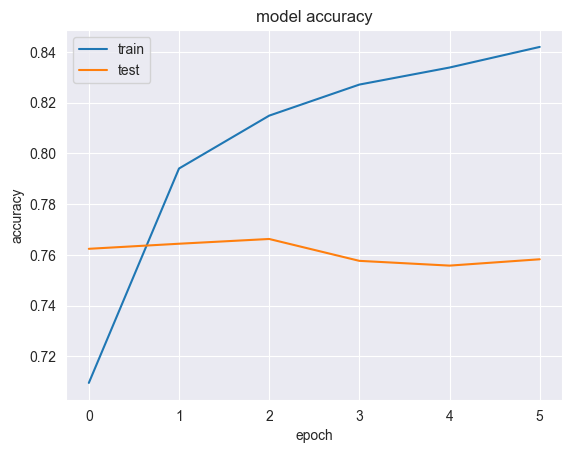

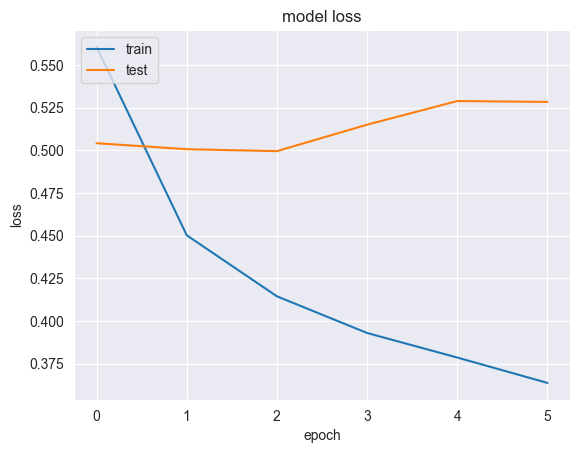

In [37]:

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [38]:
from tensorflow.keras.layers import Conv1D

In [40]:

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [41]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
cnn_model.build(input_shape=(None, 100))
print(cnn_model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 100)       │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 96, 128)        │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,303,657 (35.49 MB)

 Trainable params: 64,257 (251.00 KB)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [42]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - acc: 0.7099 - loss: 0.5465 - val_acc: 0.8322 - val_loss: 0.3780
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - acc: 0.8582 - loss: 0.3376 - val_acc: 0.8425 - val_loss: 0.3541
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - acc: 0.8904 - loss: 0.2826 - val_acc: 0.8559 - val_loss: 0.3335
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - acc: 0.9163 - loss: 0.2351 - val_acc: 0.8560 - val_loss: 0.3303
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - acc: 0.9366 - loss: 0.1934 - val_acc: 0.8551 - val_loss: 0.3306
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - acc: 0.9562 - loss: 0.1581 - val_acc: 0.8426 - val_loss: 0.3598


In [43]:
#predict test set
score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.8390 - loss: 0.3628


In [44]:
#cnn model perform
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3632175922393799
Test Accuracy: 0.8410000205039978


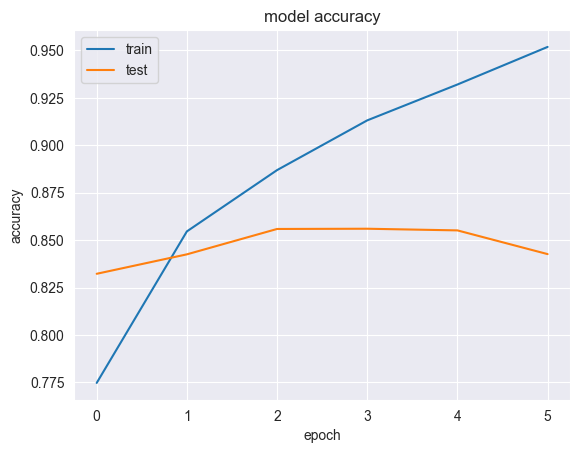

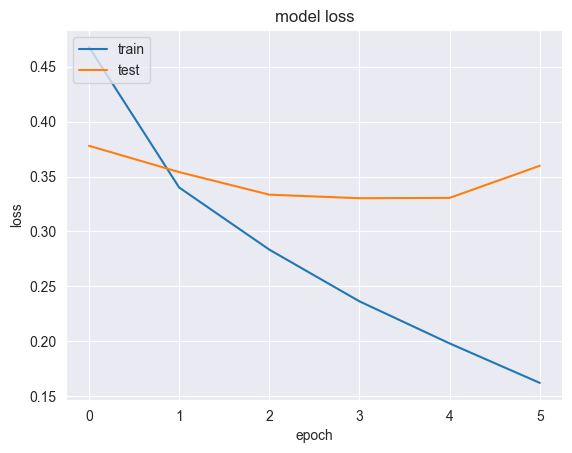

In [45]:

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [46]:
from tensorflow.keras.layers import LSTM

In [48]:

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [49]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
lstm_model.build(input_shape=(None, 100))
print(lstm_model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 100, 100)       │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,356,777 (35.69 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [50]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - acc: 0.6968 - loss: 0.5650 - val_acc: 0.8100 - val_loss: 0.4280
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - acc: 0.8070 - loss: 0.4281 - val_acc: 0.8279 - val_loss: 0.3967
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - acc: 0.8353 - loss: 0.3815 - val_acc: 0.8521 - val_loss: 0.3549
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - acc: 0.8569 - loss: 0.3411 - val_acc: 0.8576 - val_loss: 0.3272
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - acc: 0.8630 - loss: 0.3271 - val_acc: 0.8620 - val_loss: 0.3253
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - acc: 0.8703 - loss: 0.3082 - val_acc: 0.8661 - val_loss: 0.3141


In [51]:
#lstm prediction
score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - acc: 0.8636 - loss: 0.3169


In [52]:
# lstm Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3191990256309509
Test Accuracy: 0.863099992275238


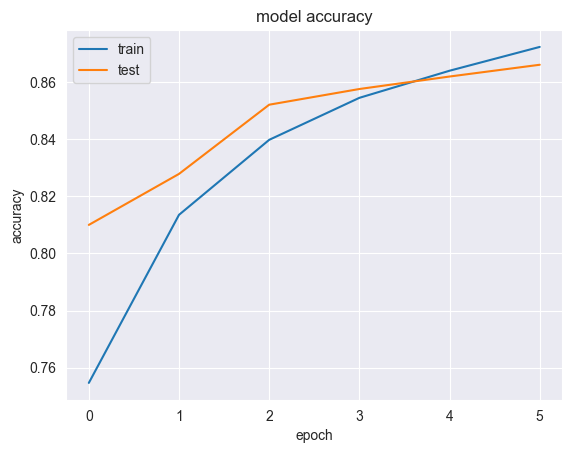

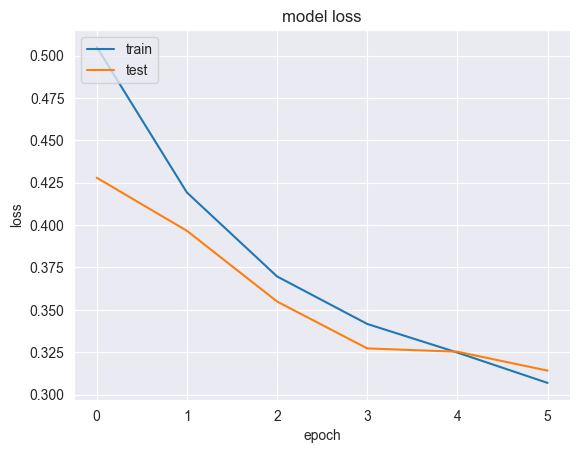

In [53]:

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [54]:
lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

In [55]:
lstm_model.save("LSTM_Model_new.keras")

In [56]:
import joblib
joblib.dump(word_tokenizer, 'lstm_tokenizer.pkl')

['lstm_tokenizer.pkl']